In [1]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

  Cloning https://github.com/deepmind/jraph.git to c:\users\alex_\appdata\local\temp\pip-req-build-wr8dzk85
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git 'C:\Users\alex_\AppData\Local\Temp\pip-req-build-wr8dzk85'


In [2]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import jit
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
import numpy as np
import pickle as p
from os import path
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import pyplot as plt
import torch
from jax import random as jrandom
from functools import partial

data_loc = 'C:/Users/alex_/Fac/M2/M2/S2/Discrete_Graphs/Projet/Data/BlogCatalog3/BlogCatalog-dataset/data/'


## Load Data

In [3]:
def load_data():
    iid = {}
    idx = 0
    sender_list = []  # List to store sender indices
    receiver_list = []  # List to store receiver indices

    # Read edges pairs
    with open(data_loc+'edges.csv', 'r') as f:
        for line in f.readlines():
            i, j = line.strip().split(',')  # csv
            if i not in iid:
                iid[i] = idx; idx += 1
            if j not in iid:
                iid[j] = idx; idx += 1
            sender_list.append(iid[i])  # Append sender index
            receiver_list.append(iid[j])  # Append receiver index
            
            # Add the reverse edge as well
            sender_list.append(iid[j])  # Append sender index
            receiver_list.append(iid[i])  # Append receiver index

    sender_array = jnp.array(sender_list)
    receiver_array = jnp.array(receiver_list)
    n_node = jnp.array([jnp.unique(sender_array).size])
    n_edge = jnp.array([len(sender_list) // 2])

    print("Number of nodes: ", n_node)
    print("Number of edges: ", n_edge)

    # Read labels
    labels = jnp.zeros((n_node), dtype=int)
    # Read (node_id, label) file
    with open(data_loc+'group-edges.csv', 'r') as f:
        for line in f.readlines():
            node, group = line.strip().split(',') 
            labels = labels.at[iid[node]].set(int(group) - 1)

    graph = jraph.GraphsTuple(
      nodes=labels,
      edges = None,
      senders=sender_array,
      receivers=receiver_array,
      n_node=n_node,
      n_edge=n_edge,
      globals = None)
    #bc_dataset = {'graph': graph, 'labels': labels}
    return graph

bc_dataset = load_data()


Number of nodes:  [10312]
Number of edges:  [333983]


In [4]:
bc_dataset.n_edge

Array([333983], dtype=int32)

## Visualizing the Graph
To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [5]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    i = 0
    print(jraph_graph.n_edge[0])
    for e in range(jraph_graph.n_edge[0]):
      if i%10000 == 0:
        print(i)
      i +=1
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

In [6]:
#The graph is too big to be displayed
#draw_jraph_graph_structure(bc_dataset)

In [7]:
print(jnp.min(bc_dataset.nodes))
print(jnp.max(bc_dataset.nodes))
unique, counts = jnp.unique(bc_dataset.nodes, return_counts=True)
print(jnp.asarray((unique, counts)).T)

0
38
[[   0   60]
 [   1  488]
 [   2  365]
 [   3  119]
 [   4  625]
 [   5  563]
 [   6  393]
 [   7 1076]
 [   8  247]
 [   9  300]
 [  10  325]
 [  11   25]
 [  12   35]
 [  13  239]
 [  14   53]
 [  15  295]
 [  16  351]
 [  17  236]
 [  18  715]
 [  19  247]
 [  20  228]
 [  21  233]
 [  22  279]
 [  23  846]
 [  24  170]
 [  25  242]
 [  26   88]
 [  27   85]
 [  28  155]
 [  29  360]
 [  30   62]
 [  31  371]
 [  32   91]
 [  33   62]
 [  34   58]
 [  35  137]
 [  36   53]
 [  37   27]
 [  38    8]]


In [8]:
def gen_random_walk_tensor(walk, graph , node, length, num_walks, rng_key):
    walk = jnp.zeros((num_walks, length), dtype=jnp.int32)
    walk = walk.at[:, 0].set(node)
    j = 0
    while j < num_walks:
        current_node = node
        step = 1
        while step < length:
            outgoing_edges = jnp.where(graph.senders == current_node)[0]
            # Extraire les nœuds destinataires des arêtes sortantes
            neighbors = jnp.take(graph.receivers, outgoing_edges)
            rng_key, subkey = jrandom.split(rng_key)
            current_node = jrandom.choice(subkey, neighbors)
            walk = walk.at[j, step].set(current_node)
            step += 1
        j += 1
    return walk, rng_key

# Assert all edges exist
num_walks = 5
length = 5
rng_key = jrandom.key(1)
walk = jnp.zeros((num_walks, length), dtype=jnp.int32)

rws, rng_key = gen_random_walk_tensor(walk,bc_dataset, 0, 5, 5,rng_key)
for walk in range(5):
    rw = rws[walk]
    for step in range(4):
        edge_exists = jnp.any(jnp.logical_and(bc_dataset.senders == rw[step], bc_dataset.receivers == rw[step+1]))
        assert edge_exists

In [9]:
rws, rng_key = gen_random_walk_tensor(walk,bc_dataset, 0, 5, 3,rng_key)
print(rws)

[[   0   91 1066 1298   40]
 [   0  101  363 3063 2255]
 [   0  103 1138  296  203]]


In [10]:
def gen_batch_random_walk(batch_walk, graph, initial_nodes, length, num_walks, rng_key):
    n_nodes = initial_nodes.shape[0]
    walk = jnp.zeros((num_walks, length), dtype=jnp.int32)
    batch_walk = jnp.zeros((num_walks * n_nodes, length), dtype=jnp.int32)
    for i, n in enumerate(initial_nodes):
        n = n.item()
        rng_key, subkey = jrandom.split(rng_key)
        sub_walk, rng_key = gen_random_walk_tensor(walk, graph, n, length, num_walks, subkey)
        batch_walk = batch_walk.at[num_walks * i:num_walks * (i + 1)].set(sub_walk)
    return walk, batch_walk , rng_key

rng_key = jrandom.key(0)
last_walk, batch_walk, rng_key = gen_batch_random_walk(walk, bc_dataset, jnp.array([0, 1]), 5, 3, rng_key)
print(batch_walk)

[[   0    3  461 5583  246]
 [   0   43 4367    9 3677]
 [   0   80 3590    8 7455]
 [   1  161  617 3846  166]
 [   1 3115   25 3082   12]
 [   1 2172   76 4535 6754]]


In [11]:
def generate_windows(windows, random_walk, window_size):
    num_walks, walk_length = random_walk.shape
    num_windows = walk_length + 1 - window_size
    windows = jnp.zeros((num_walks * num_windows, window_size), dtype=jnp.int32)
    for j in range(num_windows):
        windows = windows.at[num_walks * j:num_walks * (j + 1)].set(random_walk[:, j:j + window_size])
    return windows

windows = jnp.zeros((1,1), dtype=int)
windows = generate_windows(windows,batch_walk, 3)
print(batch_walk.shape)
print(windows.shape)

(6, 5)
(18, 3)


In [12]:
@jit
def get_windows_dotproduct(windows, embedding):
    embedding_size = embedding.shape[1]
    # get the embedding of the initial node repeated num_windows times
    first_emb = embedding[windows[:, 0]]
    first_emb = jnp.expand_dims(first_emb, axis=1)  # Ajouter une nouvelle dimension
    # get the embedding of the remaining nodes in each window
    others_emb = embedding[windows[:, 1:]]
    others_emb = others_emb.reshape(windows.shape[0], -1, embedding_size)
    # result has same shape as others
    # Each element is the dot product between the corresponding node embedding
    # and the embedding of the first node of that walk
    # that is, result_{i, j} for random walk i and element j is v_{W_{i, 0}} dot v_{W_{i, j}}
    result = jnp.sum(first_emb * others_emb, axis=-1)
    return result

embedding_jax = jax.random.normal(rng_key, shape=(12000, 300))
get_windows_dotproduct(windows, embedding_jax)

Array([[  9.989289 ,  14.355413 ],
       [  0.1050415,  -8.012434 ],
       [  8.171717 ,  22.485273 ],
       [-14.368268 ,  19.513103 ],
       [ -4.4057875,  -8.634464 ],
       [-10.255943 ,   3.4406242],
       [-11.403227 , -12.996876 ],
       [ -1.2675204,  17.343775 ],
       [ -6.70873  ,  -7.203182 ],
       [-19.548515 ,  23.787937 ],
       [  8.799166 ,  29.117088 ],
       [-23.854403 ,  -1.1407938],
       [ 37.785007 , -10.838488 ],
       [  9.711828 , -32.64926  ],
       [ -3.9425344,   1.5056596],
       [-11.72566  ,  11.133398 ],
       [  5.2066326, -15.35693  ],
       [ -1.85783  , -27.490053 ]], dtype=float32)

In [13]:
@jit
def compute_mean_log_sigmoid(windows, embedding):
    dot_product = get_windows_dotproduct(windows, embedding)
    sigmoid_output = 1 / (1 + jnp.exp(-dot_product))  # Sigmoid function
    log_sigmoid_output = jnp.log(sigmoid_output)  # Logarithm
    return jnp.mean(log_sigmoid_output)  # Mean

# Usage example:
mean_log_sigmoid = compute_mean_log_sigmoid(windows, embedding_jax)

In [14]:
def gen_negative_samples(amount, length, initial_node, number_of_nodes,rng_key):
  """Generates negative samples for a random walk process in JAX.

  Args:
    amount: Number of negative samples to generate.
    length: Length of each negative sample walk (number of nodes in the path).
    initial_node: Starting node for all negative samples.
    number_of_nodes: Total number of nodes in the graph.

  Returns:
    A JAX array of shape (amount, length) containing the negative samples.
  """
  negative_samples = jnp.zeros((amount, length), dtype=jnp.int32)  # Use jnp.int32 for node indices
  negative_samples = negative_samples.at[:, 0].set(initial_node)  # Set initial node efficiently
  rng_key, subkey = jrandom.split(rng_key)
  negative_samples = negative_samples.at[:, 1:].set(
      jrandom.randint(rng_key,shape=(amount, length - 1),minval = 0, maxval = number_of_nodes)
  )
  return negative_samples, rng_key

gen_negative_samples(amount=3, length=5, initial_node=0, number_of_nodes=2000,rng_key =rng_key)

(Array([[   0,  825,  911, 1631, 1314],
        [   0,   28, 1399, 1362,  613],
        [   0, 1806,  630, 1652,  360]], dtype=int32),
 Array((), dtype=key<fry>) overlaying:
 [3000548268 4272618543])

In [55]:
def gen_batch_negative_samples(amount, length, initial_nodes, number_of_nodes,rng_key):
  """Generates negative samples for a random walk process in JAX for a batch of initial nodes.

  Args:
    amount: Number of negative samples to generate per initial node.
    length: Length of each negative sample walk (number of nodes in the path).
    initial_nodes: A JAX array of shape (batch_size,) containing initial nodes for each sample.
    number_of_nodes: Total number of nodes in the graph.

  Returns:
    A JAX array of shape (amount * batch_size, length) containing the negative samples.
  """

  # Expand initial_nodes to match amount (amount, batch_size)
  #initial_nodes = jnp.expand_dims(initial_nodes, axis=0).repeat(amount, axis=0)
  n_nodes = initial_nodes.shape[0]
  num_walks = amount
  sub_negative_sample = jnp.zeros((num_walks, length), dtype=jnp.int32)
  batch_negative_sample = jnp.zeros((num_walks * n_nodes, length), dtype=jnp.int32)
  for i, n in enumerate(initial_nodes):
      n = n.item()
      rng_key, subkey = jrandom.split(rng_key)
      sub_negative_sample, rng_key = gen_negative_samples(amount, length, n, number_of_nodes, subkey)
      batch_negative_sample = batch_negative_sample.at[amount * i:amount * (i + 1)].set(sub_negative_sample)
  return batch_negative_sample , rng_key


# Example usage
initial_nodes = jnp.array([0, 1])
a, b =gen_batch_negative_samples(amount=3, length=5, initial_nodes=initial_nodes, number_of_nodes=2000,rng_key = rng_key)
print(a)

[[   0 1180 1940  427  957]
 [   0 1528 1469  905   90]
 [   0 1610  587  474  515]
 [   1 1402   71 1354 1003]
 [   1  205 1527 1098  918]
 [   1  859 1883 1862 1594]]


In [56]:
def generate_batches(array, batch_size):
    """Yield successive batches of size `batch_size` from `array`."""
    for i in range(0, len(array), batch_size):
        yield array[i:i + batch_size]

gen = generate_batches(list(range(101)), 20)
for batch in gen:
    print(batch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[100]


In [57]:
from tqdm import tqdm
eps = 1e-15

def deepWalk(graph, walks_per_vertex, walk_length, window_size, embedding_size, num_neg, lr, epochs, batch_size):
    number_of_nodes = jnp.array([jnp.unique(graph.senders).size])
    
    embedding = (torch.randn(size=(number_of_nodes, embedding_size)))
    embedding = jax.random.normal(rng_key, shape=(number_of_nodes, embedding_size))
    embedding.requires_grad = True
    optimizer = torch.optim.SGD([embedding], lr=lr)
    loss_history = {'pos': [], 'neg': [], 'total': []}

    for _ in range(epochs):
        nodes = torch.tensor(list(graph.nodes), dtype=int)
        random.shuffle(nodes)
        node_loader = generate_batches(nodes, batch_size)
        n_batches = int(number_of_nodes / batch_size)
        for n in tqdm(node_loader, total=n_batches):
            random_walk = gen_batch_random_walk(graph, n, walk_length, walks_per_vertex)
            num_windows = walk_length + 1 - window_size

            # Positive Sampling
            # each row of windows is one window, we have B = walks_per_vertex*num_windows windows
            windows = generate_windows(random_walk, window_size)
            batch_dotproduct = get_windows_dotproduct(windows, embedding)
            # takes the sigmoid of the dot product to get probability, then
            # takes the loglik and average through all elements
            pos_loss = -torch.log(torch.sigmoid(batch_dotproduct)+eps).mean()
            # Negative Sampling
            negative_samples = gen_batch_negative_samples(
                amount=num_neg*walks_per_vertex, 
                length=walk_length, 
                initial_nodes=n, 
                number_of_nodes=number_of_nodes
            )
            windows = generate_windows(negative_samples, window_size)
            batch_dotproduct = get_windows_dotproduct(windows, embedding)
            neg_loss = -torch.log(1-torch.sigmoid(batch_dotproduct)+eps).mean()

            loss = pos_loss + neg_loss
            # Optimization
            loss.backward()
            loss_history['total'].append(loss.detach().numpy())
            loss_history['pos'].append(pos_loss.detach().numpy())
            loss_history['neg'].append(neg_loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()  

    return embedding, loss_history

In [58]:
import jax
import jax.numpy as jnp
from jax import random
import optax
from tqdm import tqdm


### TO FIX

def deepWalk(graph, walks_per_vertex, walk_length, window_size, embedding_size, num_neg, lr, epochs, batch_size,rng_key ,eps = 1e-15):
    
    number_of_nodes = int(jnp.unique(graph.senders).size)
    
    embedding = jax.random.normal(rng_key, shape=(number_of_nodes, embedding_size))
    optimizer = optax.sgd(learning_rate=lr)
    opt_state = optimizer.init(embedding)
    loss_history = {'pos': [], 'neg': [], 'total': []}

    def loss_fn(batch_dotproduct_positive, batch_dotproduct_negative, eps = 1e-8):
        pos_loss = -jnp.log(jax.nn.sigmoid(batch_dotproduct_positive) + eps).mean()
        print("test")
        neg_loss = -jnp.log(1 - jax.nn.sigmoid(batch_dotproduct_negative) + eps).mean()
        print("essai")
        return pos_loss + neg_loss
    
    def update(params, opt_state, batch_dotproduct_positive, batch_dotproduct_negative):
        grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = grad_fn(batch_dotproduct_positive, batch_dotproduct_negative)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss

    for _ in range(epochs):
        nodes = jnp.array(list(graph.nodes), dtype=jnp.int32)
        nodes = jax.random.permutation(rng_key, nodes)
        node_loader = generate_batches(nodes, batch_size)
        n_batches = int(number_of_nodes / batch_size)
        batch_walk = 0
        for n in tqdm(node_loader, total=n_batches):
            walk, batch_walk , rng_key = gen_batch_random_walk(batch_walk, graph, n, walk_length, walks_per_vertex, rng_key)
            batch_negative_sample , rng_key = gen_batch_negative_samples(
                amount=num_neg * walks_per_vertex, 
                length=walk_length, 
                initial_nodes=n, 
                number_of_nodes=number_of_nodes,
                rng_key = rng_key
            )
            windows = 0
            windows = generate_windows(windows, batch_walk, window_size)
            batch_dotproduct_positive = get_windows_dotproduct(windows, embedding)
            windows = generate_windows(windows,batch_negative_sample, window_size)
            batch_dotproduct_negative = get_windows_dotproduct(windows, embedding)

            embedding, opt_state, loss = update(embedding, opt_state, batch_dotproduct_positive, batch_dotproduct_negative)
            loss_history['total'].append(loss)

    return embedding, loss_history


In [59]:
embedding, loss_history = deepWalk(
    graph=bc_dataset,  
    walks_per_vertex=1, 
    walk_length=2, 
    window_size=1,  
    embedding_size=128,
    num_neg=2,
    lr=0.011,
    epochs=1,
    batch_size=256,
    rng_key = rng_key
)

  0%|          | 0/40 [00:04<?, ?it/s]

test
essai


TypeError: add got incompatible shapes for broadcasting: (10312, 128), (512, 0).

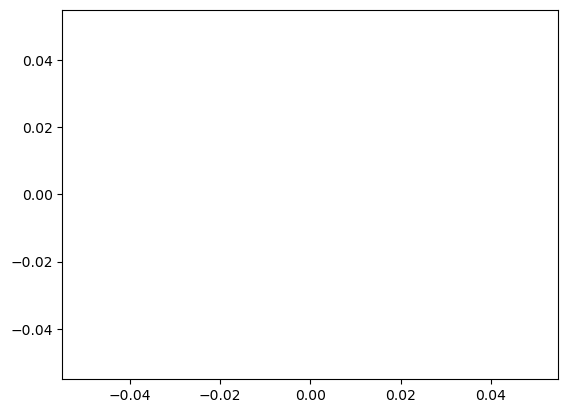

In [27]:
cumsum_vec = np.cumsum(np.insert(loss_history['total'], 0, 0)) 
window_width = 10
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)

In [ ]:
embedding

In [ ]:
X_norm = (X-X.mean(axis=0)) / X.std(axis=0)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

X = embedding.detach().numpy()
y = bc_dataset['labels']

clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X_norm, y)
y_hat = clf.predict(X_norm)
f1_score(y, y_hat, average='micro')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)


In [ ]:
plt.scatter(X_t[:, 0], X_t[:, 1], c=y)